# This script is organized as the following:
## 1) Data cleaning
## 2) Data exploration
## 3) Statistical testing
### 3.1) Stationary test
### 3.2) ACF/PACF plots
## 4) Model building
## 5) Forecasting

#### NOTE: If you want to quickly see the overview, just go to the end and read the summary

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1) Data cleaning
### - Date column is not in date format
### - Some dates are missing, i.e. category L only has half of the dates
### - Note: we are going to forecast 90 days ahead, so our basic unit is day not hours. So we will group the data into daily sales

In [2]:
np.random.seed(42)
data = pd.read_csv('../data/siteA.csv')

In [3]:
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [4]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 4 columns):
Date_Name        66160 non-null datetime64[ns]
subCategory      66160 non-null object
Purchase_Hour    66160 non-null int64
sales            66160 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB
None


In [5]:
data.head()

,Date_Name,subCategory,Purchase_Hour,sales
0,2016-02-10,A,20,8.34
1,2016-02-07,A,15,5.84
2,2016-02-28,A,18,7.38
3,2015-09-28,A,7,12.30
4,2015-09-29,A,7,24.03


In [6]:
# Group by and sum()

def func_sum(df):
    return sum(df['sales'])
temp = data.groupby(by=['Date_Name', 'subCategory']).apply(func_sum)
print temp.head()
print type(temp)

Date_Name   subCategory
2015-09-26  A                66.52
            B              1181.95
            C               713.04
            D                89.00
            E               467.63
dtype: float64
<class 'pandas.core.series.Series'>


In [7]:
# Convert grouped series back to dataframe.

temp_df = pd.DataFrame(data={'sales': temp})
temp_df.reset_index(inplace=True)
print temp_df.head()
print temp_df.shape
print temp_df.columns

   Date_Name subCategory    sales
0 2015-09-26           A    66.52
1 2015-09-26           B  1181.95
2 2015-09-26           C   713.04
3 2015-09-26           D    89.00
4 2015-09-26           E   467.63
(5259, 3)
Index([u'Date_Name', u'subCategory', u'sales'], dtype='object')


In [8]:
print temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5259 entries, 0 to 5258
Data columns (total 3 columns):
Date_Name      5259 non-null datetime64[ns]
subCategory    5259 non-null object
sales          5259 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 123.3+ KB
None


In [9]:
temp_df[temp_df['sales'] == 0]

,Date_Name,subCategory,sales


In [10]:
temp_df['summer'] = 0
temp_df.head()

,Date_Name,subCategory,sales,summer
0,2015-09-26,A,66.52,0
1,2015-09-26,B,1181.95,0
2,2015-09-26,C,713.04,0
3,2015-09-26,D,89.00,0
4,2015-09-26,E,467.63,0


In [11]:
# Feature engineering - summer or not

summer_starts = datetime.date(2016, 5, 1)
summer_ends = datetime.date(2016, 9, 1)
temp_df.loc[(temp_df['Date_Name'] >= summer_starts) & (temp_df['Date_Name'] < summer_ends), 'summer'] = 1
print temp_df[(temp_df['Date_Name'] >= summer_starts) & (temp_df['Date_Name'] < summer_ends)].head()
print temp_df.head()

      Date_Name subCategory    sales  summer
3206 2016-05-02           A    19.59       1
3207 2016-05-02           B  1696.36       1
3208 2016-05-02           C   544.14       1
3209 2016-05-02           D    30.09       1
3210 2016-05-02           E    63.37       1
   Date_Name subCategory    sales  summer
0 2015-09-26           A    66.52       0
1 2015-09-26           B  1181.95       0
2 2015-09-26           C   713.04       0
3 2015-09-26           D    89.00       0
4 2015-09-26           E   467.63       0


In [12]:
# Feature engineering - weekend or not

temp_df['weekend'] = map(lambda x: x.weekday(), temp_df['Date_Name'])
print temp_df.head()
print temp_df.tail()

   Date_Name subCategory    sales  summer  weekend
0 2015-09-26           A    66.52       0        5
1 2015-09-26           B  1181.95       0        5
2 2015-09-26           C   713.04       0        5
3 2015-09-26           D    89.00       0        5
4 2015-09-26           E   467.63       0        5
      Date_Name subCategory     sales  summer  weekend
5254 2016-09-30           M  10643.42       0        4
5255 2016-09-30           N  11572.01       0        4
5256 2016-09-30           O  11023.42       0        4
5257 2016-09-30           P     68.59       0        4
5258 2016-09-30           Q     14.49       0        4


In [13]:
# Feature engineering - extract Month and Day

temp_df['month'] = map(lambda x: x.month, temp_df['Date_Name'])
temp_df['day'] = map(lambda x: x.day, temp_df['Date_Name'])
print temp_df.head()
print temp_df.tail()

   Date_Name subCategory    sales  summer  weekend  month  day
0 2015-09-26           A    66.52       0        5      9   26
1 2015-09-26           B  1181.95       0        5      9   26
2 2015-09-26           C   713.04       0        5      9   26
3 2015-09-26           D    89.00       0        5      9   26
4 2015-09-26           E   467.63       0        5      9   26
      Date_Name subCategory     sales  summer  weekend  month  day
5254 2016-09-30           M  10643.42       0        4      9   30
5255 2016-09-30           N  11572.01       0        4      9   30
5256 2016-09-30           O  11023.42       0        4      9   30
5257 2016-09-30           P     68.59       0        4      9   30
5258 2016-09-30           Q     14.49       0        4      9   30


In [14]:
temp_df['subCategory'] = temp_df['subCategory'].astype('category').cat.codes
print temp_df.head()

   Date_Name  subCategory    sales  summer  weekend  month  day
0 2015-09-26            0    66.52       0        5      9   26
1 2015-09-26            1  1181.95       0        5      9   26
2 2015-09-26            2   713.04       0        5      9   26
3 2015-09-26            3    89.00       0        5      9   26
4 2015-09-26            4   467.63       0        5      9   26


(345,)
(345,)


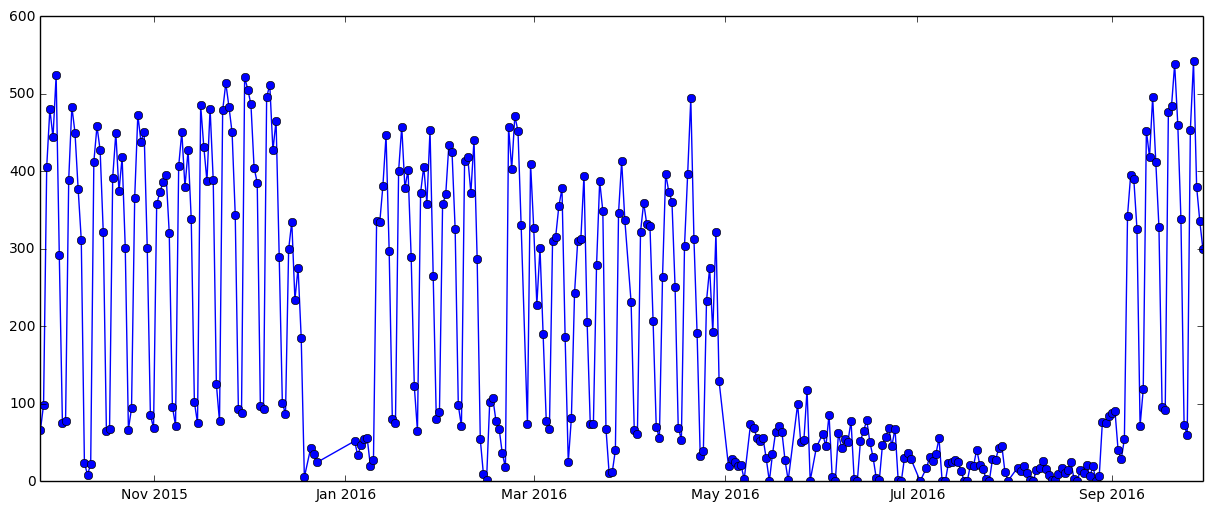

In [15]:
cat_A = temp_df[temp_df['subCategory']==0]
print cat_A['Date_Name'].shape
print cat_A['sales'].shape

plt.plot(cat_A['Date_Name'], cat_A['sales'], '-o')

# XGBoost

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
train = temp_df[['Date_Name', 'subCategory', 'summer', 'weekend', 'sales', 'month', 'day']]

In [18]:
train['Date_Name'] = (temp_df['Date_Name']-temp_df['Date_Name'].min()).astype('timedelta64[D]').astype(int)+1

In [19]:
X_train, X_test = train_test_split(train, test_size=0.10, random_state=10)

y_train = np.array(X_train.sales)
y_test = np.array(X_test.sales)
X_train = X_train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']]
X_test = X_test[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']]

In [26]:
dtrain = xgb.DMatrix(X_train, train['sales'])
dtrain

# Step 1) Find learning rate and number of estimators

In [27]:
# Custom mean squared error evaluation

def xg_eval_mse(yhat, train):
    y = train.get_label()
    return 'mse', mean_squared_error(y, yhat)

In [56]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, seed=0, \
                 feval=xg_eval_mse, maximize=False, early_stopping_rounds=15)

print 'CV score:\n', bst_cv1.iloc[-1,:]

CV score:
test-mse-mean      1.960412e+07
test-mse-std       1.815224e+06
test-rmse-mean     4.423033e+03
test-rmse-std      2.022263e+02
train-mse-mean     1.833731e+07
train-mse-std      4.195161e+05
train-rmse-mean    4.281927e+03
train-rmse-std     4.916426e+01
Name: 22, dtype: float64


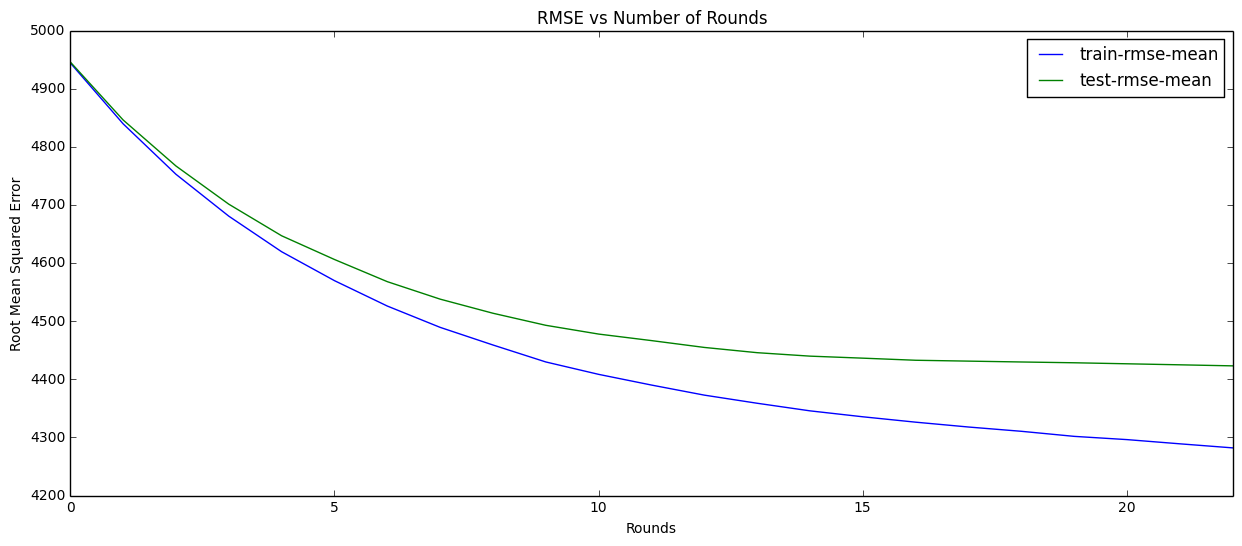

In [57]:
plt.figure()
bst_cv1[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.xlabel('Rounds')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE vs Number of Rounds')

In [173]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, 
                             dtrain=dtrain, 
                             num_boost_round=self.num_boost_round,
                             feval=xg_eval_mse, 
                             maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, 
                           dtrain=dtrain, 
                           num_boost_round=self.num_boost_round,
                           nfold=nfold, 
                           feval=xg_eval_mse, 
                           maximize=False, 
                           early_stopping_rounds=15)
        return cv_rounds
#         return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [126]:
# Grid Search with XGBoost. Tuning max_depth & min_child_weight
# xgb_model = XGBRegressor()
# xgb_params = {'max_depth': [1, 6, 9], \
#               'min_child_weight': [1, 6, 9], \
#               'subsample': [0.7], \
#               'eta': [0.05], \
#               'colsample_bytree': [0.6], \
#               'gamma': [0], \
#               'scale_pos_weight': [1], \
#               'reg_lambda':[0.9], \
#               'seed': [42]
#              }

xgb_param_grid = {'max_depth': range(1, 9), 
                  'min_child_weight': (1, 3, 5)}
xgb_grid = GridSearchCV(
    XGBoostRegressor(eta=0.1, num_boost_round=22, colsample_bytree=0.5, subsample=0.5), 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

# xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, verbose=1, scoring='neg_mean_squared_error')
# xgb_grid.fit(X_train, y_train)
score = xgb_grid.cv_results_
print("Score: ", xgb_grid.cv_results_)

('Score: ', {'rank_test_score': array([22, 22, 22, 20, 20, 19, 18, 17, 16, 13, 15, 14, 11, 12, 10,  7,  8,
        9,  5,  6,  4,  3,  2,  1], dtype=int32), 'std_score_time': array([  3.22264445e-04,   1.52818059e-04,   2.25487010e-05,
         1.14448805e-04,   2.76498129e-05,   4.74492052e-04,
         6.60234770e-04,   7.67830347e-04,   1.98803162e-04,
         1.39299670e-03,   6.63287796e-04,   8.56298640e-05,
         3.53205357e-05,   1.04007836e-04,   1.45478320e-05,
         1.97318420e-05,   3.57144391e-04,   4.38594046e-04,
         1.48425858e-05,   1.27929251e-04,   5.80998243e-06,
         1.00333156e-05,   1.44627155e-05,   2.07828117e-04]), 'split2_test_score': array([-19063996.87760133, -19063996.87760133, -19063996.87760133,
       -14061974.55363024, -14061974.55363024, -14055414.94026956,
       -10985003.68227698, -10985173.45693502, -10980084.80428042,
        -8601364.7893657 ,  -8609144.90718285,  -8609220.26891498,
        -7054199.25691848,  -7066345.56854024,

In [127]:
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))

df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
temp_params = pd.DataFrame.from_records(data=score['params'])
df = pd.concat([df, temp_params], axis=1)
print'\n'
print(df)

{'max_depth': 8, 'min_child_weight': 5}
(-5487873.703978939, 2342.6211183157507)


    rmse_train_score  rmse_test_score  max_depth  min_child_weight
0        4144.175654      4148.842858          1                 1
1        4144.175654      4148.842858          1                 3
2        4144.175654      4148.842858          1                 5
3        3623.487222      3623.636810          2                 1
4        3623.487222      3623.636810          2                 3
5        3623.446884      3623.455707          2                 5
6        3207.619500      3221.198647          3                 1
7        3207.622336      3221.132031          3                 3
8        3207.462224      3221.067360          3                 5
9        2852.588883      2889.461485          4                 1
10       2852.735384      2890.540701          4                 3
11       2853.280085      2890.156384          4                 5
12       2483.866516      2568.123789         

In [128]:
def convert_grid_scores(scores):
    _params = []
    _params_mse = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mse.append(np.sqrt(-i[1]))
    params = np.array(_params)
    grid_res = np.column_stack((_params, _params_mse))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [129]:
_, _, scores =  convert_grid_scores(xgb_grid.grid_scores_)
scores = scores.reshape(8,3)

/Library/Python/2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


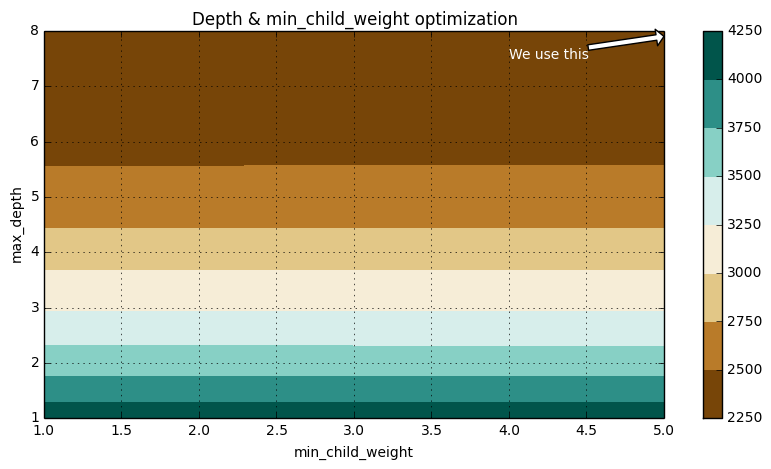

In [131]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth & min_child_weight optimization')
plt.annotate('We use this', xy=(5, 7.9), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

# Step 2 Tune Gamma to Reduce Overfitting

In [132]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

# xgb_grid = GridSearchCV(
#     XGBoostRegressor(eta=0.1, num_boost_round=22, colsample_bytree=0.5, subsample=0.5), 
#     param_grid=xgb_param_grid, 
#     cv=5, 
#     scoring='neg_mean_squared_error')

xgb_grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=22, 
                                     max_depth=8, min_child_weight=5, 
                                     colsample_bytree=0.5, subsample=0.5), 
                    param_grid=xgb_param_grid, 
                    cv=5, 
                    scoring='neg_mean_squared_error')

xgb_grid.fit(X_train, y_train)

CPU times: user 1.8 s, sys: 792 ms, total: 2.6 s
Wall time: 1.36 s


In [133]:
score = xgb_grid.cv_results_
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))

df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
temp_params = pd.DataFrame.from_records(data=score['params'])
df = pd.concat([df, temp_params], axis=1)
print'\n'
print(df)

{'gamma': 0.0}
(-5487873.703978939, 2342.6211183157507)


   rmse_train_score  rmse_test_score  gamma
0        2179.09417      2342.621118    0.0
1        2179.09417      2342.621118    0.1
2        2179.09417      2342.621118    0.2
3        2179.09417      2342.621118    0.3
4        2179.09417      2342.621118    0.4


# Step 3 Tune Subsample and colsample_bytree

In [134]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5, 10)], 
                  'colsample_bytree':[ 0.1 * i for i in range(5, 10)]}

xgb_grid = GridSearchCV(XGBoostRegressor(eta=0.1, 
                                         gamma=0, 
                                         num_boost_round=22, 
                                         max_depth=8, 
                                         min_child_weight=5), 
                    param_grid=xgb_param_grid, 
                    cv=5, 
                    scoring='neg_mean_squared_error')

xgb_grid.fit(X_train, y_train)

CPU times: user 9.98 s, sys: 4.22 s, total: 14.2 s
Wall time: 8.05 s


In [135]:
score = xgb_grid.cv_results_
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))

df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
temp_params = pd.DataFrame.from_records(data=score['params'])
df = pd.concat([df, temp_params], axis=1)
print'\n'
print(df)

{'subsample': 0.9, 'colsample_bytree': 0.9}
(-3406464.1179899238, 1845.660889218256)


    rmse_train_score  rmse_test_score  colsample_bytree  subsample
0        2179.094170      2342.621118               0.5        0.5
1        2157.167715      2334.614823               0.5        0.6
2        2142.833777      2325.085260               0.5        0.7
3        2114.923820      2296.895073               0.5        0.8
4        2100.713867      2279.986355               0.5        0.9
5        2179.094170      2342.621118               0.6        0.5
6        2157.167715      2334.614823               0.6        0.6
7        2142.833777      2325.085260               0.6        0.7
8        2114.923820      2296.895073               0.6        0.8
9        2100.713867      2279.986355               0.6        0.9
10       1947.569463      2133.369094               0.7        0.5
11       1911.314992      2117.731647               0.7        0.6
12       1893.748718      2086.737680     

/Library/Python/2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


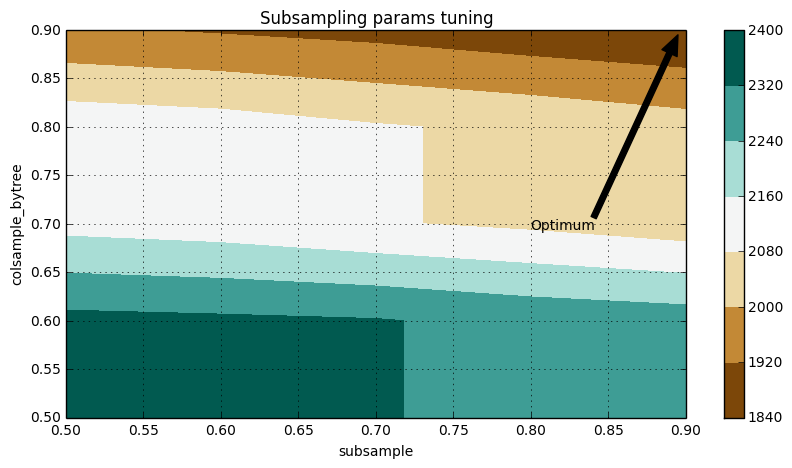

In [137]:
_, _, scores =  convert_grid_scores(xgb_grid.grid_scores_)
scores = scores.reshape(5,5)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.895), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

# Step 4 Reduce Learning Rate

In [164]:
%%time

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
num_boost_round_param = 100
xgb_grid = GridSearchCV(XGBoostRegressor(eta=0.1, 
                                         gamma=0, 
                                         num_boost_round=num_boost_round_param, 
                                         max_depth=8, 
                                         min_child_weight=5,
                                         colsample_bytree=0.9, 
                                         subsample=0.9), 
                    param_grid=xgb_param_grid, 
                    cv=5, 
                    scoring='neg_mean_squared_error')

xgb_grid.fit(X_train, y_train)

CPU times: user 16.1 s, sys: 6.9 s, total: 23 s
Wall time: 10.7 s


In [165]:
score = xgb_grid.cv_results_
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))

df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
temp_params = pd.DataFrame.from_records(data=score['params'])
df = pd.concat([df, temp_params], axis=1)
print'\n'
print(df)

{'eta': 0.1}
(-1679114.1030090067, 1295.8063524342697)


   rmse_train_score  rmse_test_score    eta
0        201.172358      1463.158700  0.500
1        240.901149      1429.136210  0.400
2        307.931062      1411.330102  0.300
3        413.149331      1353.560867  0.200
4        654.144590      1295.806352  0.100
5        760.437682      1299.119137  0.075
6        941.180549      1368.720194  0.050
7       1054.323713      1422.773709  0.040
8       1235.782966      1529.044790  0.030


/Library/Python/2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


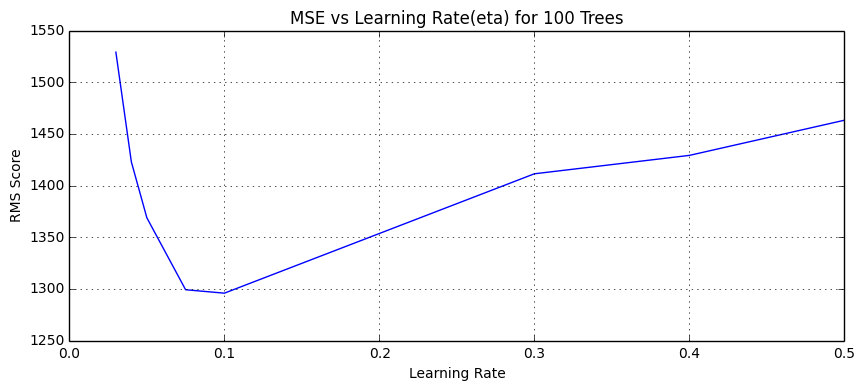

In [166]:
eta, y = convert_grid_scores(xgb_grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MSE vs Learning Rate(eta) for {} Trees'.format(num_boost_round_param))
plt.xlabel('Learning Rate')
plt.ylabel('RMS Score')
plt.plot(eta, y)
plt.grid(True)
plt.show()

# Final Model

In [174]:
%%time

bst = XGBoostRegressor(num_boost_round=100, 
                       eta=0.1, 
                       gamma=0, 
                       max_depth=8, 
                       min_child_weight=5, 
                       colsample_bytree=0.9, 
                       subsample=0.9)

cv = bst.kfold(X_train, y_train, nfold=5)

CPU times: user 1.79 s, sys: 836 ms, total: 2.62 s
Wall time: 1.5 s


In [179]:
cv.iloc[-1,:]

test-mse-mean      1.815425e+06
test-mse-std       1.040789e+06
test-rmse-mean     1.294534e+03
test-rmse-std      3.736403e+02
train-mse-mean     4.088958e+05
train-mse-std      6.037152e+04
train-rmse-mean    6.375923e+02
train-rmse-std     4.870184e+01
Name: 99, dtype: float64

In [175]:
cv

,test-mse-mean,test-mse-std,test-rmse-mean,test-rmse-std,train-mse-mean,train-mse-std,train-rmse-mean,train-rmse-std
0,2.287287e+07,2.580126e+06,4775.116699,266.697691,2.278202e+07,607312.576139,4772.624903,63.840302
1,1.923047e+07,2.332620e+06,4377.390820,262.518234,1.907606e+07,517012.367877,4367.211133,59.408148
2,1.656241e+07,1.896384e+06,4063.174805,230.252591,1.634540e+07,982771.253806,4041.166455,119.904653
3,1.449026e+07,1.972110e+06,3797.841015,258.195888,1.418600e+07,759450.310067,3765.086426,100.621513
4,1.251505e+07,1.903791e+06,3527.746875,264.675242,1.213841e+07,512362.486147,3483.247510,73.431331
5,1.128019e+07,1.734214e+06,3349.121582,252.150382,1.081412e+07,385768.495425,3287.952881,59.058408
6,9.900479e+06,1.503473e+06,3137.961182,231.687963,9.419522e+06,629338.407639,3067.439844,101.662433
7,8.565318e+06,1.463960e+06,2916.682031,241.420481,8.070826e+06,539245.749933,2839.356738,94.229376
8,7.763527e+06,1.381948e+06,2775.798096,241.810147,7.257117e+06,707168.321482,2690.788477,129.517334
9,7.011586e+06,1.300339e+06,2636.982861,240.640156,6.464157e+06,646715.784010,2539.318067,126.573252


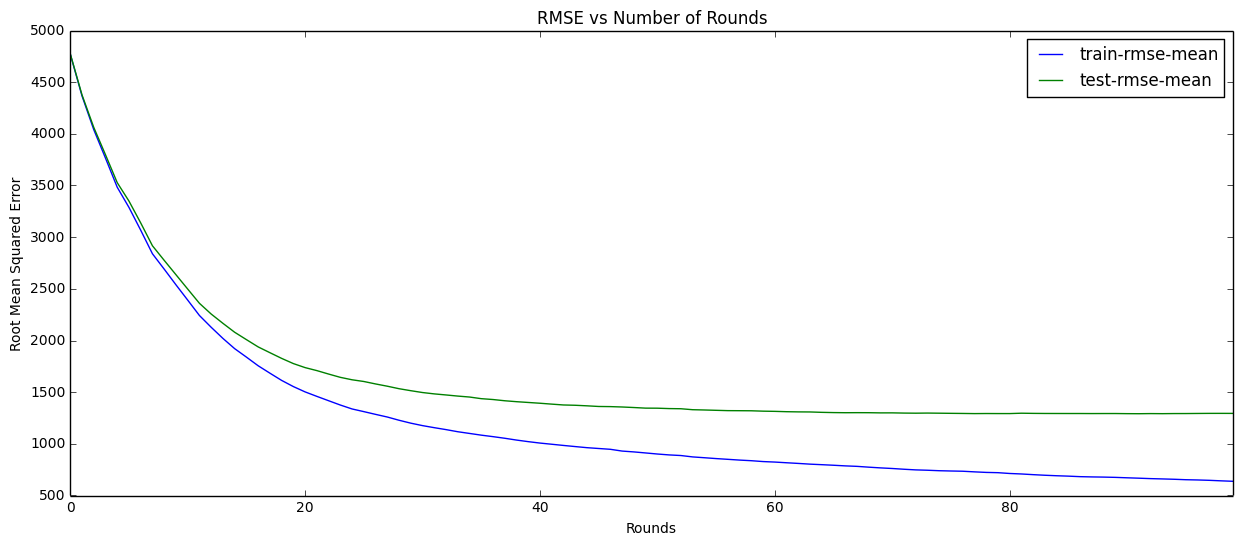

In [176]:
plt.figure()
cv[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.xlabel('Rounds')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE vs Number of Rounds')

In [ ]:
xgb_pred = xgb_grid.predict(X_test)
print xgb_pred.head()

np.savetxt('xgb_test_pred_3.txt', xgb_pred)
sqrt(mean_squared_error(y_test, xgb_pred))

Train:  (4733, 6)
Test:  (526, 6)


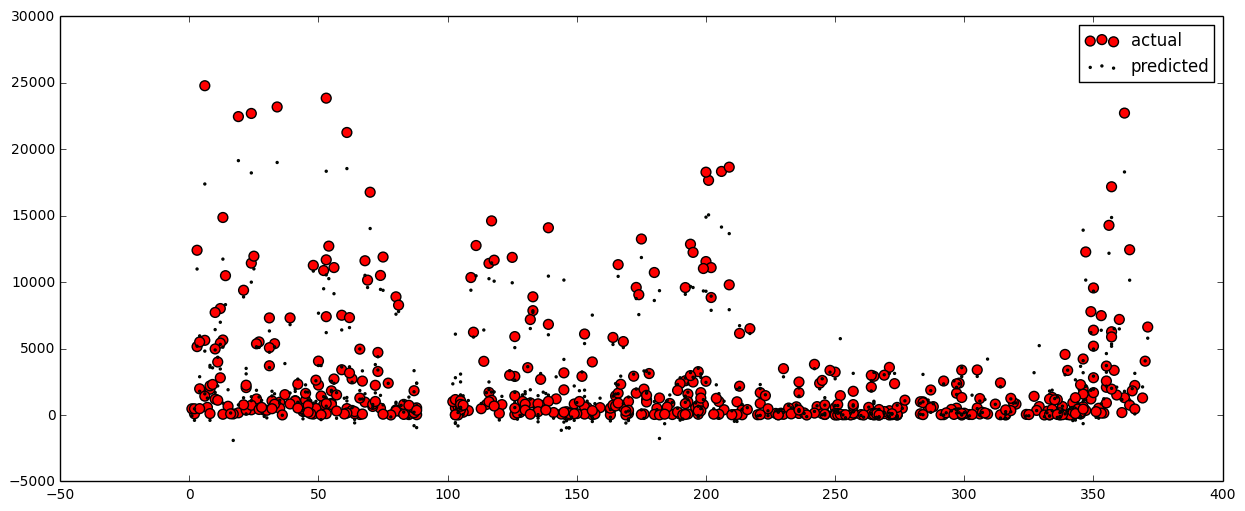

In [54]:
print 'Train: ', X_train.shape
print 'Test: ', X_test.shape
plt.scatter(X_test['Date_Name'], y_test, c='red', s=50, label='actual')
plt.scatter(X_test['Date_Name'], xgb_pred, c='green', s=2, label='predicted')
plt.legend()

In [177]:
print train.tail(16)
np.sort(train['subCategory'].unique())

      Date_Name  subCategory  summer  weekend     sales  month  day
5243        371            0       0        4    299.56      9   30
5244        371            1       0        4   6623.06      9   30
5245        371            2       0        4   2506.76      9   30
5246        371            3       0        4    782.44      9   30
5247        371            4       0        4    621.09      9   30
5248        371            5       0        4  16210.05      9   30
5249        371            6       0        4   2413.91      9   30
5250        371            7       0        4   6004.38      9   30
5251        371            8       0        4   2034.84      9   30
5252        371            9       0        4   1024.24      9   30
5253        371           10       0        4   1092.61      9   30
5254        371           11       0        4  10643.42      9   30
5255        371           12       0        4  11572.01      9   30
5256        371           13       0        4  1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [180]:
# Create 90 days ahead dataframe for prediction.

idx = pd.date_range('10-01-2016', '12-30-2016')
new_idx = []
for day, item in enumerate(idx):
    for i in range(0, 16):
        new_idx.append(item)


future_df = pd.DataFrame(data={'Date_Name': new_idx})
print day
print future_df.head()
print future_df.shape
print future_df.tail()

subCategory = range(0, 16)*91
future_df['subCategory'] = subCategory

# New features: summer and weekend.
future_df['summer'] = 0
# summer_starts = datetime.date(2017, 5, 1)
# summer_ends = datetime.date(2017, 9, 1)
# future_df.loc[(future_df['Date_Name'] >= summer_starts) & (future_df['Date_Name'] < summer_ends), 'summer'] = 1
# print future_df[(future_df['Date_Name'] >= summer_starts) & (future_df['Date_Name'] < summer_ends)].head()
# print future_df.head()

# Weekend.
future_df['weekend'] = map(lambda x: x.weekday(), future_df['Date_Name'])

# Feature engineering - extract Month and Day
future_df['month'] = map(lambda x: x.month, future_df['Date_Name'])
future_df['day'] = map(lambda x: x.day, future_df['Date_Name'])

# Convert date to numerical sequence.
future_df['Date_Name'] = (future_df['Date_Name']-future_df['Date_Name'].min()).astype('timedelta64[D]').astype(int)+372

print future_df.head()
print future_df.tail()

90
   Date_Name
0 2016-10-01
1 2016-10-01
2 2016-10-01
3 2016-10-01
4 2016-10-01
(1456, 1)
      Date_Name
1451 2016-12-30
1452 2016-12-30
1453 2016-12-30
1454 2016-12-30
1455 2016-12-30
   Date_Name  subCategory  summer  weekend  month  day
0        372            0       0        5     10    1
1        372            1       0        5     10    1
2        372            2       0        5     10    1
3        372            3       0        5     10    1
4        372            4       0        5     10    1
      Date_Name  subCategory  summer  weekend  month  day
1451        462           11       0        4     12   30
1452        462           12       0        4     12   30
1453        462           13       0        4     12   30
1454        462           14       0        4     12   30
1455        462           15       0        4     12   30


In [181]:
xgb_90 = xgb_grid.predict(future_df)

In [182]:
print type(xgb_90)
final_df = pd.DataFrame(data=future_df)
final_df['sales'] = xgb_90
future_df = future_df.drop('sales', axis=1)
print 'Final: \n', final_df.head()
print 'Future: \n', future_df.head()

<type 'numpy.ndarray'>
Final: 
   Date_Name  subCategory  summer  weekend  month  day       sales
0        372            0       0        5     10    1 -184.006317
1        372            1       0        5     10    1  729.171326
2        372            2       0        5     10    1  -14.132579
3        372            3       0        5     10    1 -377.540588
4        372            4       0        5     10    1 -401.174133
Future: 
   Date_Name  subCategory  summer  weekend  month  day
0        372            0       0        5     10    1
1        372            1       0        5     10    1
2        372            2       0        5     10    1
3        372            3       0        5     10    1
4        372            4       0        5     10    1


In [183]:
final_df = final_df.groupby(by=['Date_Name'])['sales'].sum()
print final_df.head()
old_sales = train.groupby(by=['Date_Name'])['sales'].sum()
print old_sales.head()

Date_Name
372    10839.638672
373    12408.063477
374    82793.640625
375    90392.875000
376    91067.257812
Name: sales, dtype: float32
Date_Name
1    14588.23
2    15143.61
3    84535.83
4    94145.18
5    91173.07
Name: sales, dtype: float64


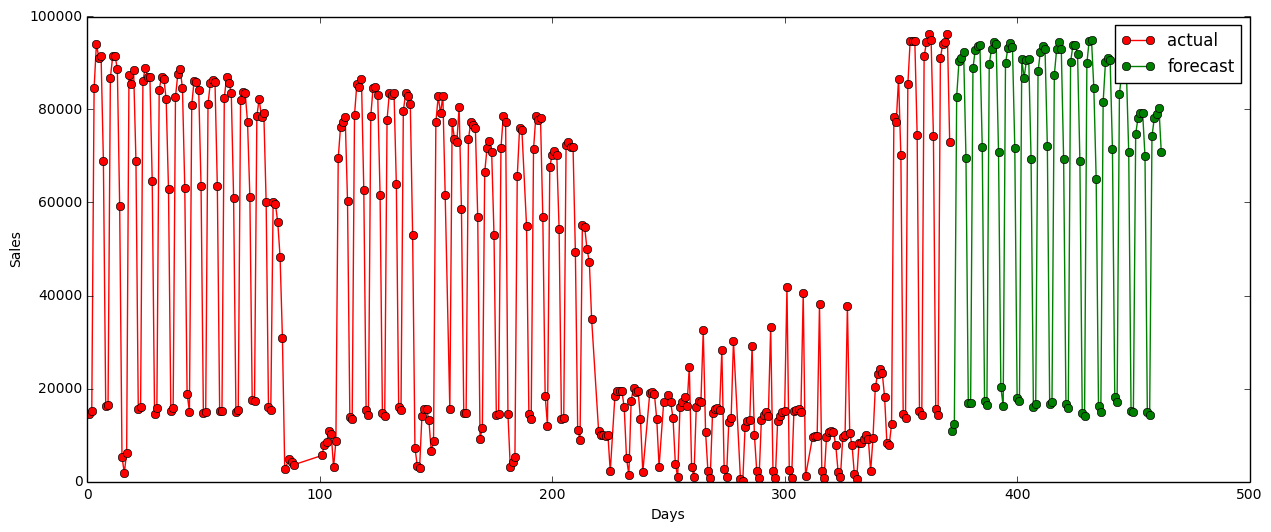

In [187]:
plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(final_df.index, final_df, '-o', c='green', label='forecast')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()

In [185]:
xgb_in_sample = xgb_grid.predict(train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']])

In [186]:
# Benchmark RMSE 2: 713.1613025362668
# Benchmark RMSE: 1657.888
sqrt(mean_squared_error(train['sales'], xgb_in_sample))

706.9477735943888

In [63]:
print type(xgb_in_sample)
in_sample_df = pd.DataFrame(data=train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']])
in_sample_df['sales'] = xgb_in_sample
print 'Train: \n', train.head()
print 'In Sample: \n', in_sample_df.head()

in_sample_df = in_sample_df.groupby(by=['Date_Name'])['sales'].sum()
print in_sample_df.head()

<type 'numpy.ndarray'>
Train: 
   Date_Name  subCategory  summer  weekend    sales  month  day
0          1            0       0        5    66.52      9   26
1          1            1       0        5  1181.95      9   26
2          1            2       0        5   713.04      9   26
3          1            3       0        5    89.00      9   26
4          1            4       0        5   467.63      9   26
In Sample: 
   Date_Name  subCategory  summer  weekend  month  day        sales
0          1            0       0        5      9   26  -256.943939
1          1            1       0        5      9   26  1343.761841
2          1            2       0        5      9   26   441.798767
3          1            3       0        5      9   26  -196.741196
4          1            4       0        5      9   26   -67.336075
Date_Name
1    15209.885742
2    16082.518555
3    81996.281250
4    94869.859375
5    90041.640625
Name: sales, dtype: float32


In [64]:
# Benchmark RMSE 2: 1540.270
# Benchmark RMSE: 2864.868
sqrt(mean_squared_error(old_sales, in_sample_df))

3040.35095795879

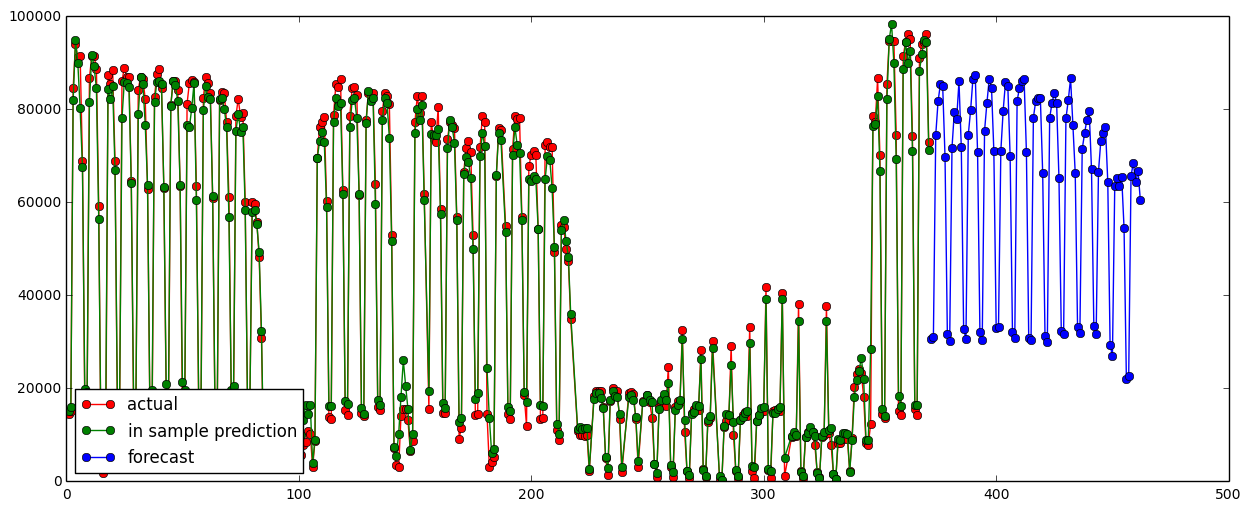

In [65]:
# After Gridsearch Tuning 2nd time. Parameters used:
# xgb_params = {'colsample_bytree': 0.6, 
#                 'scale_pos_weight': 1, 
#                 'learning_rate': 0.01, 
#                 'min_child_weight': 1, 
#                 'n_estimators': 500, 
#                 'subsample': 0.7, 
#                 'reg_lambda': 0.9, 
#                 'seed': 42, 
#                 'max_depth': 9, 
#                 'gamma': 0}
# (-2774307.817099561, 1665.6253531630578)

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend(loc='lower left')

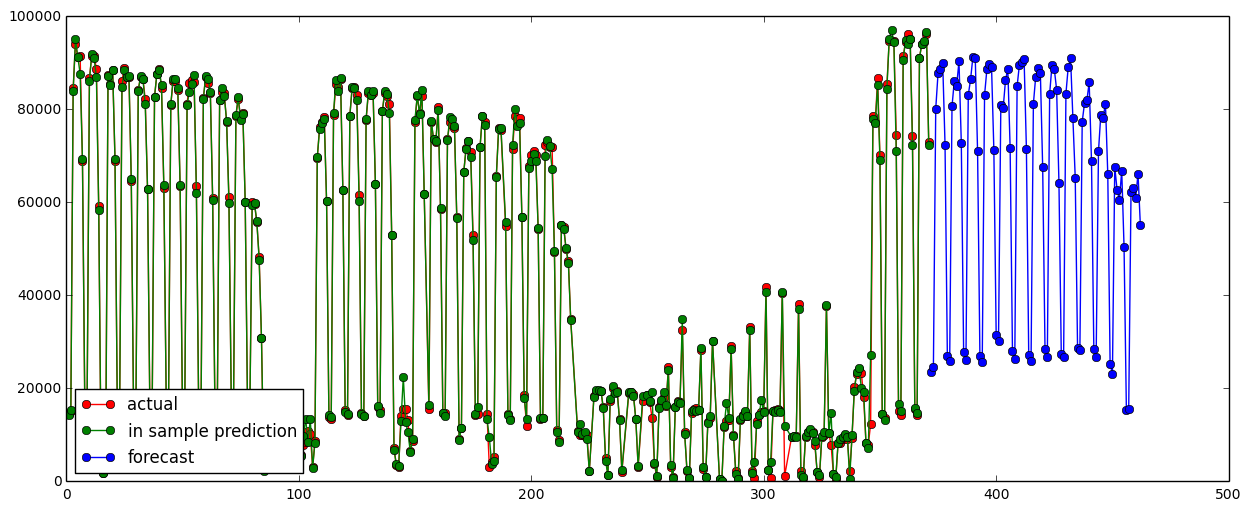

In [50]:
# After Gridsearch Tuning
# xgb_params = {'max_depth': [6], \
#               'subsample': [0.7], \
#               'n_estimators': [500], \
#               'learning_rate': [0.01], \
#               'colsample_bytree': [0.6], \
#               'min_child_weight': [1.25], \
#               'gamma': [0], \
#               'scale_pos_weight': [1], \
#               'reg_lambda':[0.9], \
#               'seed': [42]
#              }

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend(loc='lower left')

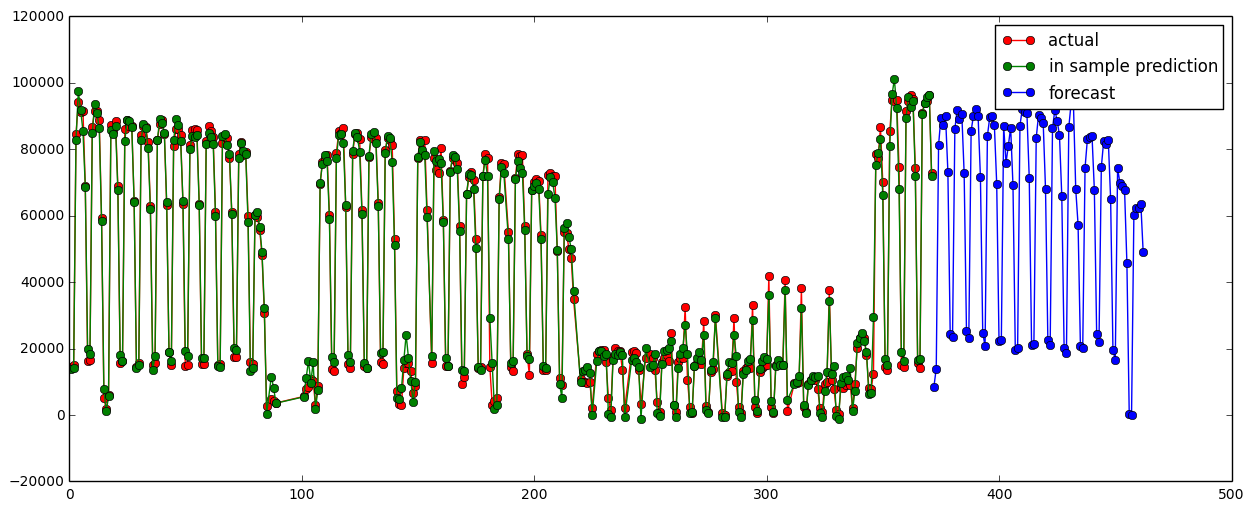

In [33]:
# Before Gridsearch Tuning. Parameters used:
# xgb_params = {'max_depth': [3], \
#               'subsample': [0.7], \
#               'n_estimators': [5003], \
#               'learning_rate': [0.01], \
#               'colsample_bytree': [0.6], \
#               'min_child_weight': [1.25], \
#               'gamma': [0], \
#               'scale_pos_weight': [1], \
#               'reg_lambda':[0.9], \
#               'seed': [42]
#              }

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend()